##  Pre-processing and Training Data Development

In [1]:
import pandas as pd
import numpy as np

In [2]:
diabetic_df = pd.read_csv('../data/diabetic_data_preprocessed2.csv',low_memory=False)

diabetic_df.shape

(100241, 44)

In [3]:
diabetic_df.head().T

,0,1,2,3,4
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Male,Male,Male
age,10-20,20-30,30-40,40-50,70-80
max_glu_serum,None,None,None,None,None
A1Cresult,None,None,None,None,None
metformin,No,No,No,No,No
repaglinide,No,No,No,No,No
nateglinide,No,No,No,No,No
chlorpropamide,No,No,No,No,No
glimepiride,No,No,No,No,No


### Feature Engineering
Create dummy features for object type features

In [4]:
dummies_df = diabetic_df.drop(['readmitted'], axis = 1)                      
X = pd.get_dummies(dummies_df, drop_first=True)

#### Split the data into test and train subsamples

In [5]:
from sklearn.model_selection import train_test_split

y = diabetic_df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)

### Data Modeling

In [6]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [7]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [8]:
clf = RandomForestClassifier(n_estimators=200, random_state = 1,n_jobs=-1)

#model_res = clf.fit(X_train_scaled, y_train)
#y_pred = model_res.predict(X_test_scaled)

model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

#y_pred_prob = model_res.predict_proba(X_test_scaled)

#lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy = %.3f' % (ac))
print('Random Forest: f1-score = %.3f' % (f1))

Random Forest: Accuracy = 0.576
Random Forest: f1-score = 0.525


In [9]:
#Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['NO','>30','<30'], 
                     columns = ['NO','>30','<30'])

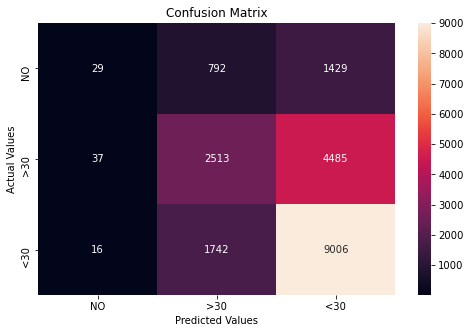

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting the confusion matrix
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

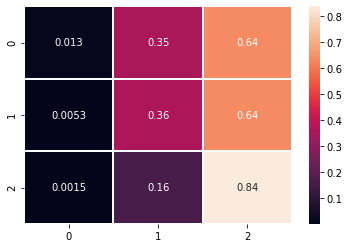

In [11]:
#Create normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, linewidths = 0.01);

#### Feature Importance

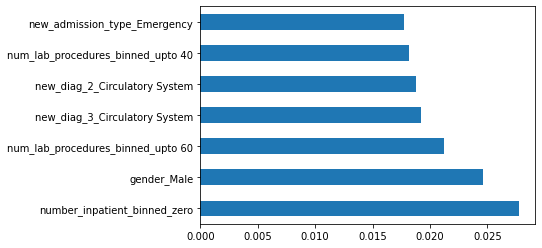

In [12]:
feat_importances = pd.Series(model_res.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh');

## Data Modeling using Pycaret

### Setting up the Environment in PyCaret

In [13]:
from pycaret.classification import *

In [14]:
# setup the dataset
# fix_imbalance -- When training dataset has unequal distribution of target class it can be balanced using this parameter
# When set to True, SMOTE (Synthetic Minority Over-sampling Technique) is applied by default to create synthetic datapoints for minority class.
# fix_imbalance_method that is used here is 'imblearn.over_sampling.SMOTE' 

#clf1 = setup(data = diabetic_df, target='readmitted', fix_imbalance= True, session_id=123)
clf1 = setup(data = diabetic_df, target='readmitted', session_id=123)

,Description,Value
0,session_id,123
1,Target,readmitted
2,Target Type,Multiclass
3,Label Encoded,"<30: 0, >30: 1, NO: 2"
4,Original Data,"(100241, 44)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,43
8,Ordinal Features,False
9,High Cardinality Features,False


### Comparing All Models

In [15]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.5852,0.6700,0.4122,0.5566,0.5385,0.1945,0.2082,8.4390
xgboost,Extreme Gradient Boosting,0.5822,0.6645,0.4111,0.5469,0.5368,0.1905,0.2032,16.2720
lightgbm,Light Gradient Boosting Machine,0.5820,0.6663,0.4047,0.5441,0.5303,0.1813,0.1975,0.4380
gbc,Gradient Boosting Classifier,0.5798,0.6602,0.4001,0.5413,0.5244,0.1716,0.1901,11.4770
lr,Logistic Regression,0.5770,0.6505,0.3984,0.5168,0.5227,0.1678,0.1848,11.0380
lda,Linear Discriminant Analysis,0.5767,0.6504,0.3985,0.5314,0.5226,0.1675,0.1843,0.6820
ridge,Ridge Classifier,0.5763,0.0000,0.3965,0.4984,0.5200,0.1638,0.1819,0.1360
rf,Random Forest Classifier,0.5760,0.6472,0.4020,0.5406,0.5262,0.1717,0.1861,3.6220
ada,Ada Boost Classifier,0.5757,0.6414,0.3969,0.5136,0.5207,0.1645,0.1816,0.9790
et,Extra Trees Classifier,0.5716,0.6422,0.4028,0.5293,0.5264,0.1698,0.1814,5.8810


### Create Models

Choosing these models for further assessment:
- CatBoost Classifier
- Light Gradient Boosting Machine 
- Extreme Gradient Boosting

#### CatBoost Classifier

In [16]:
#creating a model

catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5794,0.6617,0.4053,0.5331,0.5312,0.1818,0.1951
1,0.5906,0.6731,0.4172,0.5719,0.5440,0.2044,0.2190
2,0.5843,0.6756,0.4108,0.5544,0.5370,0.1918,0.2057
3,0.5826,0.6676,0.4106,0.5411,0.5372,0.1924,0.2043
4,0.5859,0.6724,0.4122,0.5535,0.5390,0.1961,0.2095
5,0.5924,0.6786,0.4197,0.5786,0.5469,0.2099,0.2239
6,0.5800,0.6673,0.4063,0.5464,0.5314,0.1814,0.1957
7,0.5859,0.6735,0.4144,0.5535,0.5407,0.1984,0.2113
8,0.5854,0.6641,0.4123,0.5792,0.5373,0.1914,0.2068
9,0.5859,0.6662,0.4130,0.5546,0.5399,0.1978,0.2105


#### Light Gradient Boosting Machine

In [17]:
 lightgbm = create_model('lightgbm')           

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5770,0.6571,0.3990,0.5228,0.5233,0.1681,0.1851
1,0.5856,0.6674,0.4091,0.5693,0.5355,0.1903,0.2060
2,0.5813,0.6745,0.4036,0.5461,0.5290,0.1788,0.1953
3,0.5790,0.6656,0.4021,0.5211,0.5274,0.1758,0.1912
4,0.5864,0.6685,0.4089,0.5475,0.5358,0.1916,0.2076
5,0.5871,0.6710,0.4098,0.5534,0.5364,0.1928,0.2092
6,0.5772,0.6616,0.4001,0.5338,0.5244,0.1701,0.1863
7,0.5799,0.6679,0.4031,0.5306,0.5286,0.1785,0.1936
8,0.5840,0.6651,0.4054,0.5667,0.5306,0.1826,0.2005
9,0.5827,0.6642,0.4059,0.5501,0.5318,0.1841,0.1996


In [18]:
  print(lightgbm)              

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


#### Extreme Gradient Boosting

In [19]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5752,0.6538,0.4046,0.5397,0.5290,0.1753,0.1875
1,0.5844,0.6666,0.4137,0.5459,0.5401,0.1963,0.2087
2,0.5819,0.6718,0.4107,0.5480,0.5365,0.1901,0.2025
3,0.5823,0.6610,0.4111,0.5384,0.5373,0.1913,0.2039
4,0.5854,0.6656,0.4137,0.5465,0.5402,0.1971,0.2101
5,0.5918,0.6745,0.4205,0.5669,0.5477,0.2112,0.2241
6,0.5803,0.6619,0.4073,0.5470,0.5324,0.1830,0.1969
7,0.5752,0.6643,0.4054,0.5301,0.5302,0.1781,0.1896
8,0.5834,0.6619,0.4110,0.5509,0.5361,0.1892,0.2039
9,0.5824,0.6634,0.4131,0.5558,0.5388,0.1938,0.2052


In [20]:
print(xgboost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)


### Tune Models
This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC by fold for the best model. 

#### CatBoost Classifier

In [21]:
tuned_catboost = tune_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5746,0.6559,0.3953,0.4968,0.5186,0.1605,0.1781
1,0.5861,0.6664,0.4052,0.5092,0.5314,0.1852,0.2042
2,0.5806,0.6680,0.4003,0.5026,0.5253,0.1738,0.1919
3,0.5750,0.6569,0.3968,0.4975,0.5206,0.1638,0.1804
4,0.5843,0.6652,0.4038,0.5068,0.5297,0.1822,0.2005
5,0.5800,0.6673,0.3999,0.5016,0.5245,0.1729,0.1909
6,0.5836,0.6574,0.4013,0.5059,0.5260,0.1765,0.1973
7,0.5786,0.6620,0.3990,0.5002,0.5235,0.1706,0.1880
8,0.5800,0.6569,0.3992,0.5016,0.5238,0.1715,0.1901
9,0.5832,0.6610,0.4028,0.5060,0.5283,0.1793,0.1978


##### Tuning catboost gave us a lightly lower value, so with go with original catboost value

#### Light Gradient Boosting Machine

In [22]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5749,0.6600,0.4028,0.5127,0.5284,0.1761,0.1875
1,0.5856,0.6668,0.4110,0.5599,0.5380,0.1947,0.2083
2,0.5779,0.6724,0.4048,0.5269,0.5307,0.1808,0.1930
3,0.5803,0.6633,0.4086,0.5449,0.5347,0.1878,0.1994
4,0.5873,0.6696,0.4136,0.5277,0.5416,0.2021,0.2142
5,0.5909,0.6759,0.4197,0.5802,0.5465,0.2089,0.2217
6,0.5816,0.6630,0.4072,0.5329,0.5333,0.1855,0.1995
7,0.5867,0.6724,0.4137,0.5439,0.5410,0.2003,0.2128
8,0.5834,0.6585,0.4094,0.5704,0.5348,0.1878,0.2025
9,0.5801,0.6618,0.4074,0.5132,0.5344,0.1886,0.1997


##### Tuned Light Gradient Boosting machine gave slightly better result

#### Extreme Gradient Boosting

In [23]:
tuned_xgboost = tune_model(xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5767,0.6570,0.4017,0.5476,0.5260,0.1717,0.1867
1,0.5877,0.6695,0.4114,0.5778,0.5377,0.1937,0.2103
2,0.5823,0.6710,0.4062,0.5499,0.5319,0.1835,0.1990
3,0.5842,0.6660,0.4082,0.5427,0.5347,0.1889,0.2039
4,0.5870,0.6691,0.4095,0.5285,0.5369,0.1938,0.2095
5,0.5844,0.6765,0.4090,0.5569,0.5349,0.1891,0.2044
6,0.5792,0.6612,0.4022,0.5418,0.5268,0.1746,0.1911
7,0.5867,0.6694,0.4103,0.5557,0.5367,0.1931,0.2090
8,0.5830,0.6656,0.4064,0.5634,0.5313,0.1826,0.1995
9,0.5852,0.6627,0.4082,0.5426,0.5348,0.1894,0.2052


##### Tuned xgboost performed better 

### Plot Models

#### CatBoost Classifier

##### Confusion Matrix

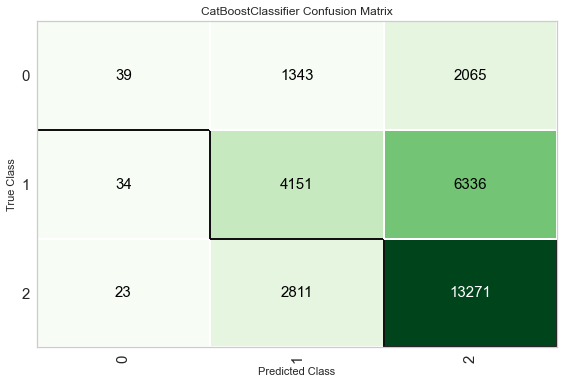

In [24]:
plot_model(catboost, plot = 'confusion_matrix')

##### Classification Report

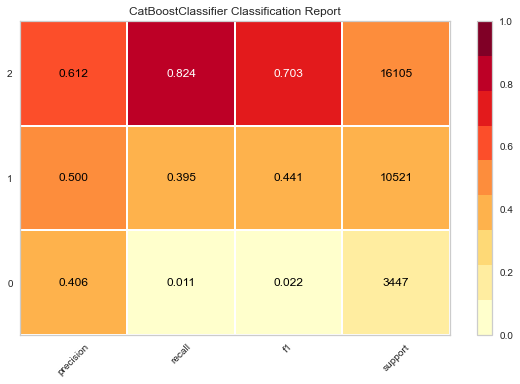

In [25]:
plot_model(catboost, plot = 'class_report')

##### AUC

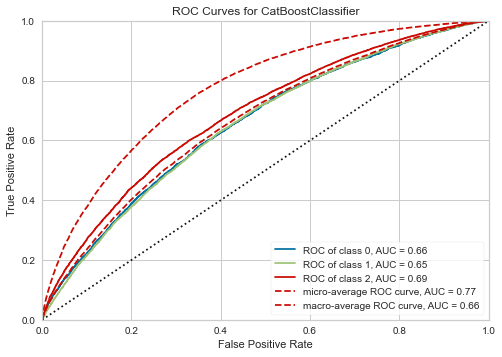

In [26]:
plot_model(catboost, plot = 'auc')

##### Feature Importance

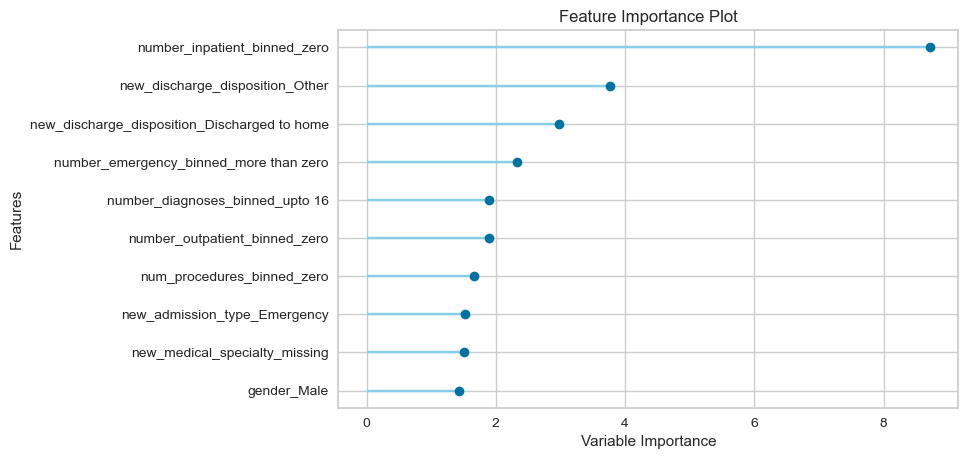

In [27]:
plot_model(catboost, plot = 'feature')

##### Decision Boundary Plot

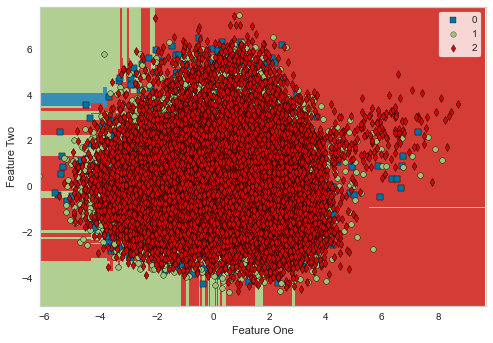

In [28]:
plot_model(catboost, plot = 'boundary')

##### Prediction Error Plot

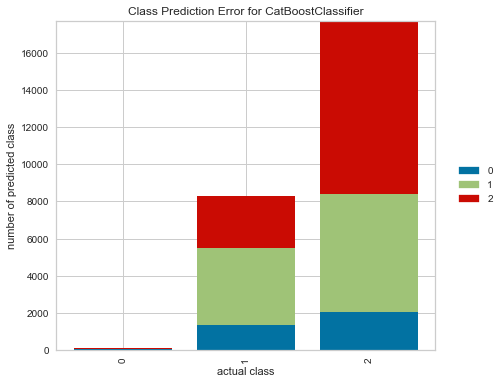

In [29]:
plot_model(catboost, plot = 'error')

#### Light Gradient Boosting Machine   

##### Confusion Matrix

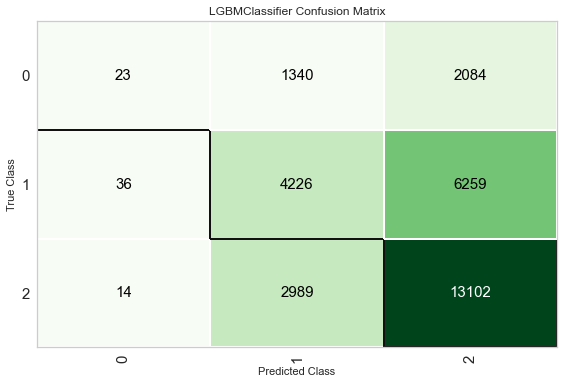

In [30]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

##### Classification Report

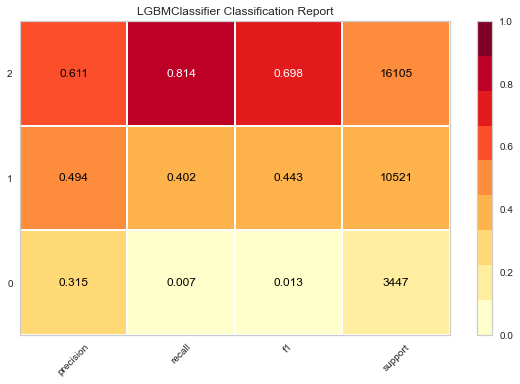

In [31]:
plot_model(tuned_lightgbm, plot = 'class_report')

##### AUC

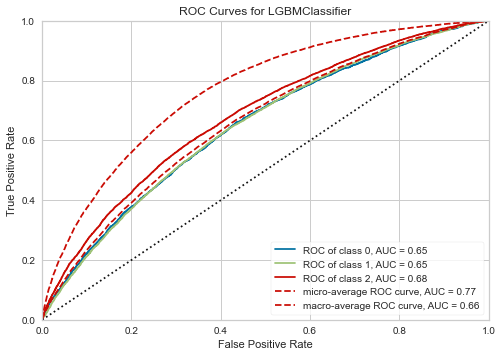

In [32]:
plot_model(tuned_lightgbm, plot = 'auc')

##### Feature Importance

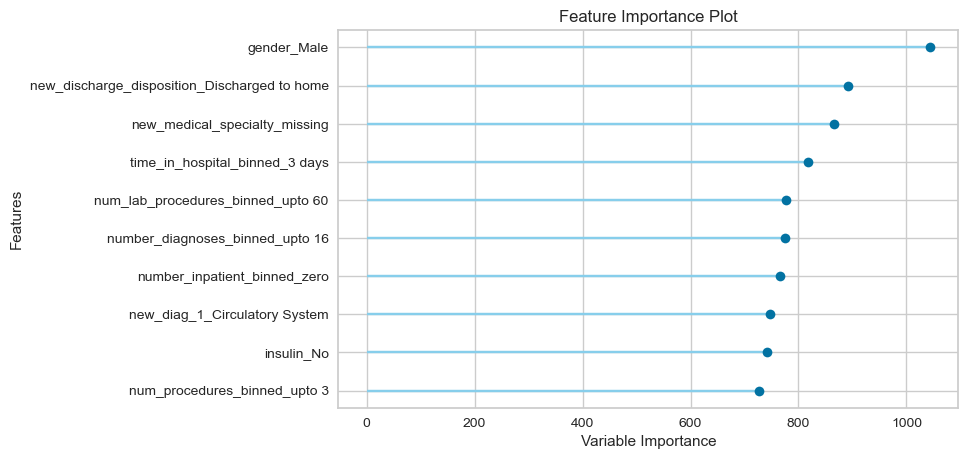

In [33]:
plot_model(tuned_lightgbm, plot = 'feature')

##### Decision Boundary Plot

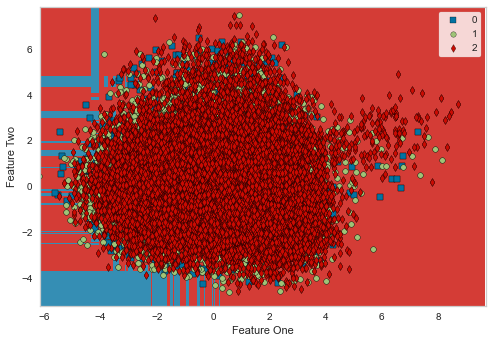

In [34]:
plot_model(tuned_lightgbm, plot = 'boundary')

##### Prediction Error Plot

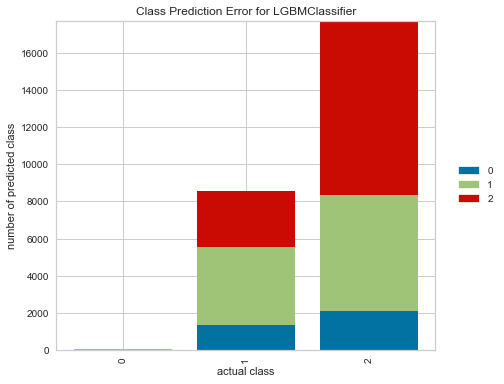

In [35]:
plot_model(tuned_lightgbm, plot = 'error')

#### Extreme Gradient Boosting

##### Confusion Matrix

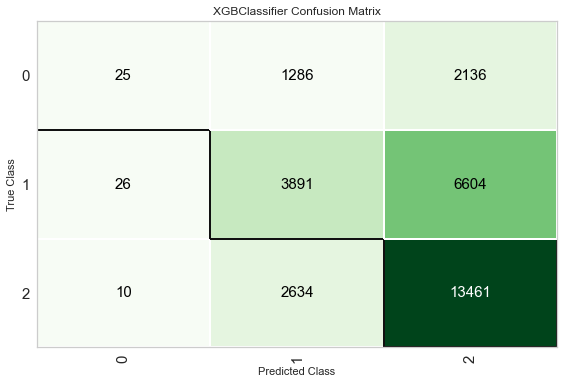

In [36]:
plot_model(tuned_xgboost, plot = 'confusion_matrix')

##### Classification Report

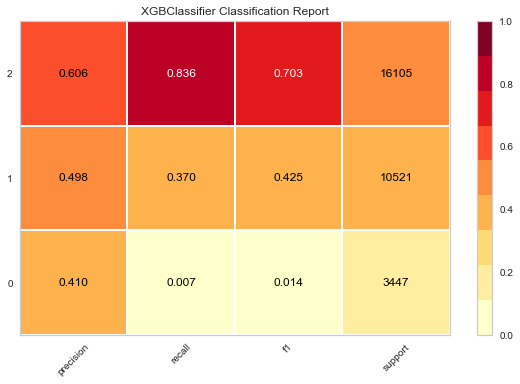

In [37]:
plot_model(tuned_xgboost, plot = 'class_report')

##### AUC

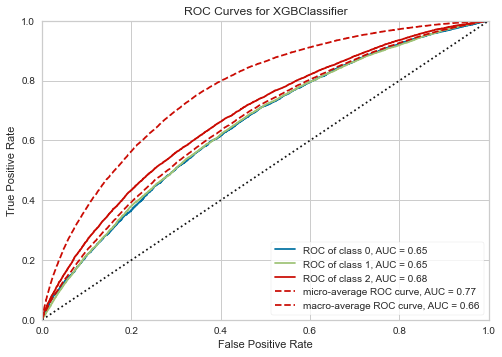

In [38]:
plot_model(tuned_xgboost, plot = 'auc')

##### Feature Importance

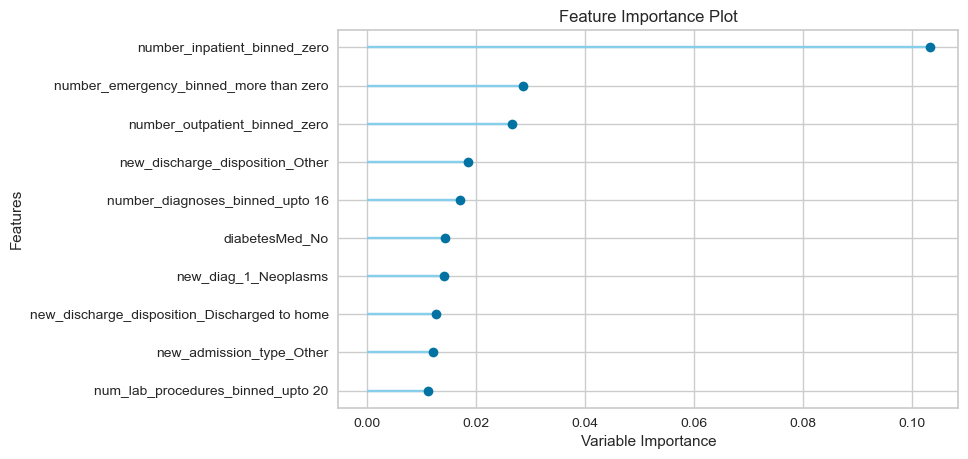

In [39]:
plot_model(tuned_xgboost, plot = 'feature')

##### Decision Boundary Plot

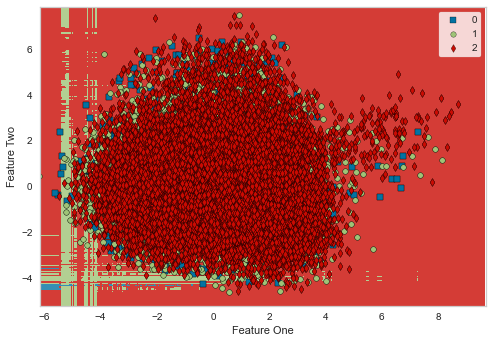

In [40]:
plot_model(tuned_xgboost, plot = 'boundary')

##### Prediction Error Plot

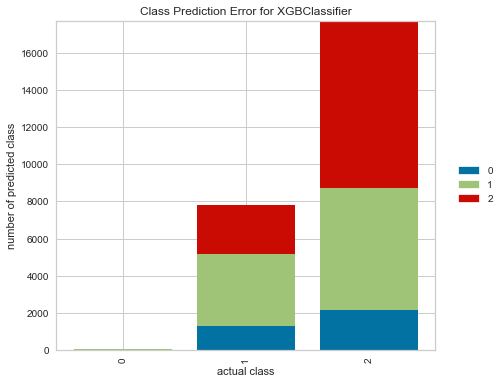

In [41]:
plot_model(tuned_xgboost, plot = 'error')

### Prediction

#### CatBoost Classifier

In [42]:
predict_model(catboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.5806,0.6706,0.4100,0.5494,0.5331,0.1890,0.2022


##### Light Gradient Boosting Machine

In [43]:
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5770,0.6649,0.4073,0.5361,0.5302,0.1838,0.1956


##### Extreme Gradient Boosting

In [44]:
predict_model(tuned_xgboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5778,0.6670,0.4043,0.5460,0.5265,0.1779,0.1931
